# Installation

In [ ]:
# pip install torch transformers datasets dotenv scikit-learn tqdm matplotlib

# Persona Extractor

## Pre Processing

Loads the dataset and extracts unique relation labels.

Builds mappings (relation2id and id2relation) for training and decoding the relation classifier.

In [1]:
import json

data_path = "data/ConvAI2/u2t_map_all.json"
with open(data_path, "r") as f:
    raw_data = json.load(f)


# Extract all unique relations
all_relations = sorted({ex["triplets"][0]["label"] for ex in raw_data})     # like: ['favorite_movie', 'like_food', 'scared_of', ...]
relation2id = {rel: i for i, rel in enumerate(all_relations)}               # For the encoding step 
id2relation = {i: rel for rel, i in relation2id.items()}                    # For the decoding step
print(f"Loaded {len(raw_data)} examples with {len(relation2id)} relation types.\n")

print("First 10 relation labels:")
for i, rel in enumerate(all_relations[:10]):
    print(f"{i:>2}: {rel}")


Loaded 35077 examples with 105 relation types.

First 10 relation labels:
 0: allergy_to
 1: attend_school
 2: belief
 3: collect
 4: diet
 5: dislike
 6: dislike_activity
 7: dislike_animal
 8: dislike_color
 9: dislike_drink


**BIO Tagging using head, relationship and tail ids:**

B: Beginning, I: Inside, O: Outside.

The output tags:

- B-SUB: Beginning of the subject span

- B-OBJ / I-OBJ: Beginning and inside of the object span

- O: Tokens not relevant to the triplet

Reference: https://arxiv.org/abs/cs/0306050

In [2]:
def convert_to_bio(example):
    triplet = example["triplets"][0]
    tokens = triplet["tokens"]
    head = triplet["head"]
    tail = triplet["tail"]
    relation = triplet["label"]

    labels = ['O'] * len(tokens)
    for idx in head:
        labels[idx] = 'B-SUB'
    if isinstance(tail, list):
        for i, idx in enumerate(tail):
            labels[idx] = 'B-OBJ' if i == 0 else 'I-OBJ'

    return {
        "tokens": tokens,
        "labels": labels,
        "relation_label": relation2id[relation]
    }

bio_data = [convert_to_bio(ex) for ex in raw_data if "triplets" in ex and ex["triplets"]]

from pprint import pprint

print("Sample BIO-formatted training example:\n")
pprint(bio_data[0])


Sample BIO-formatted training example:

{'labels': ['B-SUB', 'O', 'O', 'O', 'O', 'O', 'B-OBJ', 'O'],
 'relation_label': 30,
 'tokens': ['i', 'just', 'got', 'done', 'watching', 'a', 'horror', 'movie']}


## Model Training

In [3]:
MAX_LENGTH = 256
BATCH_SIZE = 16
EPOCHS = 10
TRAIN_SPLIT = 0.8

In [4]:
from torch.utils.data import Dataset, DataLoader, random_split
from transformers import BertTokenizerFast, BertModel
from transformers import  get_scheduler
from torch.optim import AdamW
from tqdm import tqdm
from torch import nn
import torch
import os

This cell tokenizes each example using the BERT tokenizer and aligns word-level BIO labels with the resulting subword tokens. It also attaches the relation label as an integer, preparing the data for joint token and sentence-level classification.


In [5]:
tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased")

label_list = ['O', 'B-SUB', 'B-OBJ', 'I-OBJ']
label2id = {label: i for i, label in enumerate(label_list)}
id2label = {i: label for label, i in label2id.items()}

def tokenize_and_align(example):
    assert len(example["labels"]) == len(example["tokens"]), "Token-label length mismatch"

    encoding = tokenizer(example["tokens"], is_split_into_words=True, padding="max_length", truncation=True, max_length=MAX_LENGTH)
    word_ids = encoding.word_ids()

    aligned_labels = []
    prev_word_id = None
    for word_id in word_ids:
        if word_id is None:
            aligned_labels.append(-100)
        else:
            aligned_labels.append(label2id[example["labels"][word_id]])
        prev_word_id = word_id

    encoding["labels"] = aligned_labels
    encoding["relation_label"] = example["relation_label"]
    return encoding

tokenized_data = [tokenize_and_align(ex) for ex in bio_data]

Defines a PyTorch Dataset to wrap your tokenized input.

Prepares DataLoaders for training and evaluation.

In [6]:
class JointPersonaDataset(Dataset):
    def __init__(self, encodings):
        self.data = encodings

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        return {
            "input_ids": torch.tensor(item["input_ids"]),
            "attention_mask": torch.tensor(item["attention_mask"]),
            "labels": torch.tensor(item["labels"]),
            "relation_label": torch.tensor(item["relation_label"])
        }

dataset = JointPersonaDataset(tokenized_data)
train_size = int(TRAIN_SPLIT * len(dataset))
train_dataset, val_dataset = random_split(dataset, [train_size, len(dataset) - train_size])
train_loader = DataLoader(train_dataset, batch_size= BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size= BATCH_SIZE)

This model jointly performs:

- Token classification (BIO tags for subject/object)

- Sentence classification (relation type)

It uses a single BERT encoder with two output heads.

In [7]:
class JointBertExtractor(nn.Module):
    def __init__(self, base_model='bert-base-uncased', num_token_labels=4, num_relation_labels=0):
        super(JointBertExtractor, self).__init__()
        self.bert = BertModel.from_pretrained(base_model)

        self.dropout = nn.Dropout(0.1)
        self.token_classifier = nn.Linear(self.bert.config.hidden_size, num_token_labels)
        self.relation_classifier = nn.Linear(self.bert.config.hidden_size, num_relation_labels)

    def forward(self, input_ids, attention_mask, labels=None, relation_label=None):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        sequence_output = self.dropout(outputs.last_hidden_state)
        cls_output = self.dropout(outputs.pooler_output)

        token_logits = self.token_classifier(sequence_output)  # [batch_size, seq_len, num_token_labels]
        relation_logits = self.relation_classifier(cls_output)  # [batch_size, num_relation_labels]

        loss = None
        if labels is not None and relation_label is not None:
            loss_fct = nn.CrossEntropyLoss()
            token_loss = loss_fct(token_logits.view(-1, token_logits.shape[-1]), labels.view(-1))
            relation_loss = loss_fct(relation_logits, relation_label)
            loss = token_loss + relation_loss

        return {
            "loss": loss,
            "token_logits": token_logits,
            "relation_logits": relation_logits
        }

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = JointBertExtractor(
    num_token_labels=len(label2id),
    num_relation_labels=len(relation2id)
).to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=3e-5)
num_epochs = EPOCHS
num_training_steps = num_epochs * len(train_loader)

lr_scheduler = get_scheduler(
    "linear", optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps
)

In [9]:
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt

def compute_token_f1(preds, labels):
    true_labels = []
    true_preds = []
    for pred, label in zip(preds, labels):
        for p, l in zip(pred, label):
            if l != -100:
                true_labels.append(l)
                true_preds.append(p)
    return f1_score(true_labels, true_preds, average="macro")


In [10]:
%%time
train_losses = []
val_f1s = []

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    loop = tqdm(train_loader, desc=f"Epoch {epoch+1}", leave=False)

    for batch in loop:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(
            input_ids=batch["input_ids"],
            attention_mask=batch["attention_mask"],
            labels=batch["labels"],
            relation_label=batch["relation_label"]
        )

        loss = outputs["loss"]
        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        total_loss += loss.item()
        loop.set_postfix(loss=loss.item())

    avg_train_loss = total_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Validation: token-level F1
    model.eval()
    val_preds, val_labels = [], []
    with torch.no_grad():
        for batch in val_loader:
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(
                input_ids=batch["input_ids"],
                attention_mask=batch["attention_mask"]
            )
            token_logits = outputs["token_logits"]
            preds = torch.argmax(token_logits, dim=-1)

            val_preds.extend(preds.cpu().tolist())
            val_labels.extend(batch["labels"].cpu().tolist())

    f1 = compute_token_f1(val_preds, val_labels)
    val_f1s.append(f1)

    tqdm.write(f"[Epoch {epoch+1}] Loss: {avg_train_loss:.4f} | Val F1: {f1:.4f}")


[Epoch 1] Loss: 2.5851 | Val F1: 0.8154


[Epoch 2] Loss: 1.4134 | Val F1: 0.8382


[Epoch 3] Loss: 0.9163 | Val F1: 0.8496


[Epoch 4] Loss: 0.6168 | Val F1: 0.8600


[Epoch 5] Loss: 0.4287 | Val F1: 0.8648


[Epoch 6] Loss: 0.3000 | Val F1: 0.8696


[Epoch 7] Loss: 0.2117 | Val F1: 0.8732


[Epoch 8] Loss: 0.1575 | Val F1: 0.8775


[Epoch 9] Loss: 0.1185 | Val F1: 0.8785


[Epoch 10] Loss: 0.0975 | Val F1: 0.8803
CPU times: user 36min 44s, sys: 9.22 s, total: 36min 53s
Wall time: 36min 42s


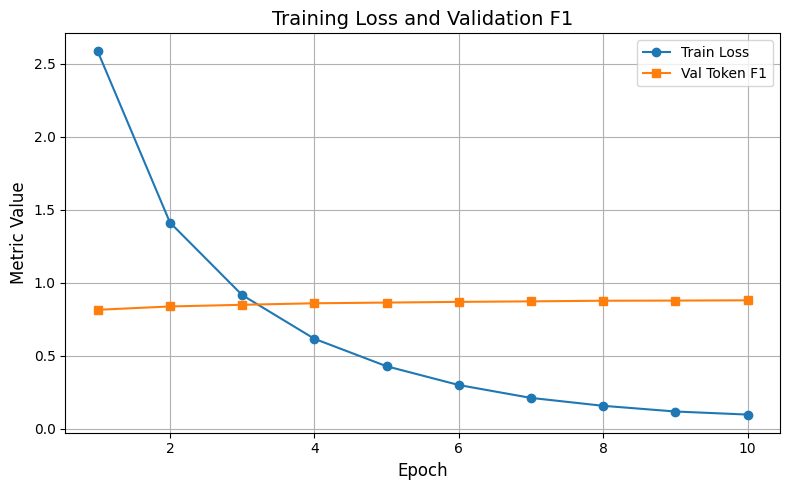

In [13]:
import os
import matplotlib.pyplot as plt

# Create and format the plot
plt.figure(figsize=(8, 5))
plt.plot(range(1, num_epochs + 1), train_losses, label="Train Loss", marker='o')
plt.plot(range(1, num_epochs + 1), val_f1s, label="Val Token F1", marker='s')
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Metric Value", fontsize=12)
plt.title("Training Loss and Validation F1", fontsize=14)
plt.legend()
plt.grid(True)
plt.tight_layout()

# Save to PDF with proper formatting
plt.savefig("Figures/loss_f1_plot.pdf", format='pdf', dpi=300, bbox_inches='tight')

# Also show inline
plt.show()

In [12]:
model_save_path = "PExtractor"
tokenizer.save_pretrained(model_save_path)
torch.save(model.state_dict(), os.path.join(model_save_path, "pytorch_model.bin"))
print(f"Model saved to {model_save_path}")

Model saved to PExtractor


## Model Testing

In [ ]:
from transformers import BertTokenizerFast, BertModel
from torch import nn
import torch

In [ ]:
class JointBertExtractor(nn.Module):
    def __init__(self, base_model='bert-base-uncased', num_token_labels=4, num_relation_labels=0):
        super(JointBertExtractor, self).__init__()
        self.bert = BertModel.from_pretrained(base_model)

        self.dropout = nn.Dropout(0.1)
        self.token_classifier = nn.Linear(self.bert.config.hidden_size, num_token_labels)
        self.relation_classifier = nn.Linear(self.bert.config.hidden_size, num_relation_labels)

    def forward(self, input_ids, attention_mask, labels=None, relation_label=None):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        sequence_output = self.dropout(outputs.last_hidden_state)
        cls_output = self.dropout(outputs.pooler_output)

        token_logits = self.token_classifier(sequence_output)
        relation_logits = self.relation_classifier(cls_output)

        loss = None
        if labels is not None and relation_label is not None:
            loss_fct = nn.CrossEntropyLoss()
            token_loss = loss_fct(token_logits.view(-1, token_logits.shape[-1]), labels.view(-1))
            relation_loss = loss_fct(relation_logits, relation_label)
            loss = token_loss + relation_loss

        return {
            "loss": loss,
            "token_logits": token_logits,
            "relation_logits": relation_logits
        }


In [ ]:
model_path = "PExtractor"  # adjust if saved elsewhere
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

tokenizer = BertTokenizerFast.from_pretrained(model_path)
model = JointBertExtractor(num_token_labels=4, num_relation_labels=105)  # 105 = your # of relation classes
model.load_state_dict(torch.load(f"{model_path}/pytorch_model.bin", map_location=device))
model.to(device)
model.eval()


In [ ]:
# Token-level labels
label_list = ['O', 'B-SUB', 'B-OBJ', 'I-OBJ']
id2label = {i: label for i, label in enumerate(label_list)}

# Relation labels (recreate from training set)
import json
with open("data/ConvAI2/u2t_map_all.json", "r") as f:
    raw_data = json.load(f)
relation_list = sorted({ex["triplets"][0]["label"] for ex in raw_data})
id2relation = {i: rel for i, rel in enumerate(relation_list)}


In [ ]:
def extract_triplet_joint(sentence: str, model, tokenizer, id2label, id2relation, device="cpu"):
    model.eval()
    inputs = tokenizer(sentence, return_tensors="pt", truncation=True, padding="max_length", max_length=128)
    inputs = {k: v.to(device) for k, v in inputs.items()}

    with torch.no_grad():
        outputs = model(input_ids=inputs["input_ids"], attention_mask=inputs["attention_mask"])

    token_preds = torch.argmax(outputs["token_logits"], dim=-1).squeeze().cpu().tolist()
    tokens_decoded = tokenizer.convert_ids_to_tokens(inputs["input_ids"].squeeze())
    attention_mask = inputs["attention_mask"].squeeze().cpu().tolist()

    subject = None
    obj_tokens = []

    for token, label_id, mask in zip(tokens_decoded, token_preds, attention_mask):
        if mask == 0 or token in ["[PAD]", "[CLS]", "[SEP]"]:
            continue  # skip padding tokens
        label = id2label.get(label_id, "O")
        if label == "B-SUB":
            subject = token
        elif label.startswith("B-OBJ") or label.startswith("I-OBJ"):
            obj_tokens.append(token)


    rel_pred_id = torch.argmax(outputs["relation_logits"], dim=-1).item()
    relation = id2relation[rel_pred_id]
    object_str = tokenizer.convert_tokens_to_string(obj_tokens).strip()
    subject = subject if subject else "i"

    return (subject, relation, object_str)


In [ ]:
# test_sent = "I used to play vollyball but now, i am playing soccer."

# test_sent = "I don’t enjoy horror movies as much as I used to."           # cond1

# test_sent = "My sister loves rom-coms, but I prefer horror movies."

test_sent = "My sister loves funny movies."                                   # cond2          

# test_sent = "His soul feeds on horror flicks and cold pizza."               # cond3

s, r, o = extract_triplet_joint(test_sent, model, tokenizer, id2label, id2relation, device)
print(f"Extracted Triplet: ({s}, {r}, {o})")